In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10


x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

rotation = np.identity(dim_in)
rotation[1,0] = 1
rotation[2,0] = 1
rotation[3,1] = rotation[4,1] = 1

y_train = simulate_y(x_train, rotation)

y_test = simulate_y(x_test, rotation)

sample_range = [100, 200, 400, 800, 1600]

n_estimators = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

rotation

ModuleNotFoundError: No module named 'Mondrian_forest'

In [2]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

In [3]:
np.set_printoptions(precision=5, suppress=True)
true_H/two_one_norm(true_H)

Array([[0.41535, 0.51755, 0.41535, 0.1022 , 0.1022 ],
       [0.51755, 1.10785, 0.51755, 0.5903 , 0.5903 ],
       [0.41535, 0.51755, 0.41535, 0.1022 , 0.1022 ],
       [0.1022 , 0.5903 , 0.1022 , 0.4881 , 0.4881 ],
       [0.1022 , 0.5903 , 0.1022 , 0.4881 , 0.4881 ]], dtype=float32)

In [4]:
np.linalg.matrix_rank(true_H)

2

# Save training history

In [5]:
y_train.shape

(2000,)

In [15]:
lifetime = 5
from Mondrian_RF.Mondrian_forest import MondrianForestTransformer

# Mondrian Forest
forests = {}
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    forests[n_sim] = []
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        forest = MondrianForestTransformer(n_estimators=n_estimators, lifetime=lifetime, step_size=0.2, random_state=n_sim * (trial + 1))
        forest.fit(x_train[:n_sim], y_train[:n_sim])
        forests[n_sim].append(forest)

100%|██████████| 10/10 [01:53<00:00, 11.37s/it]


In [16]:
H_est = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'H': []}
    for trial in tqdm(range(tries)):
        H_0 = forests[n_sim][trial].estimate_H_finite_diff()
        dist['H'].append(H_0)
    H_est.append(dist)

100%|██████████| 10/10 [01:17<00:00,  7.77s/it]


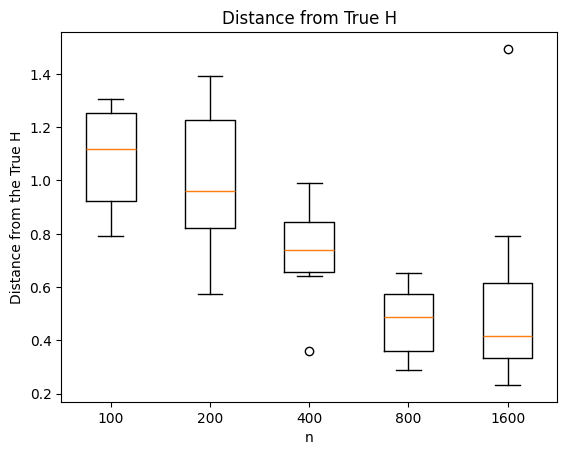

In [17]:
from util import *
plot_H_estimates(H_est, true_H, get_angle_distance, sample_range, active)

In [18]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, n_estimators, lifetime_max, delta))

In [19]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, n_estimators, lifetime_max, delta))

In [20]:
H_1 = H_est[4]['H'][0]/two_one_norm(H_est[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_1, x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, n_estimators, lifetime_max, delta))

In [21]:
# subset results[0][0]['times'] whose indices mod 10 == 0

def process_times(times):
    return [times[i] for i in range(len(times)) if i % 10 == 0]

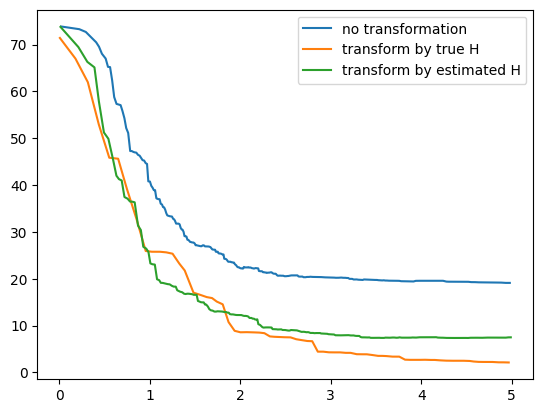

In [22]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()